In [1]:
import os
import neat

In [2]:
import copy
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled',
                       'shape': 'box'}
        input_attrs['fillcolor'] = node_colors.get(k, 'lightgray')
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled'}
        node_attrs['fillcolor'] = node_colors.get(k, 'lightblue')

        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add((cg.in_node_id, cg.out_node_id))

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            #if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

In [4]:
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,), (1.0,), (1.0,), (0.0,)]


 ****** Running generation 0 ****** 

Population's average fitness: 2.19136 stdev: 0.35550
Best fitness: 2.98934 - size: (1, 2) - species 1 - id 92
Average adjusted fitness: 0.557
Mean genetic distance 1.157, standard deviation 0.398
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150      3.0    0.557     0
Total extinctions: 0
Generation time: 0.021 sec

 ****** Running generation 1 ****** 

Population's average fitness: 2.40939 stdev: 0.32326
Best fitness: 2.99479 - size: (1, 2) - species 1 - id 156
Average adjusted fitness: 0.552
Mean genetic distance 1.203, standard deviation 0.465
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150      3.0    0.552     0
Total extinctions: 0
Generation time: 0.020 sec (0.020 average)

 ****** Running generation 2 ****** 

Population's average fitness: 2.34581 stdev: 0

Mean genetic distance 1.755, standard deviation 0.543
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   23    54      3.1    0.566     1
     2   13    96      3.0    0.648     4
Total extinctions: 0
Generation time: 0.025 sec (0.030 average)

 ****** Running generation 24 ****** 

Population's average fitness: 2.37306 stdev: 0.46441
Best fitness: 3.05849 - size: (2, 3) - species 1 - id 3365
Average adjusted fitness: 0.654
Mean genetic distance 1.793, standard deviation 0.571
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   24    71      3.1    0.609     2
     2   14    79      3.0    0.699     5
Total extinctions: 0
Generation time: 0.031 sec (0.030 average)

 ****** Running generation 25 ****** 

Population's average fitness: 2.37464 stdev: 0.47437
Best fitness: 3.05849 - size: (2, 3) - species 1 - id 3365
Average adju

Mean genetic distance 2.613, standard deviation 1.146
Population of 151 members in 6 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   42    25      3.5    0.333     3
     2   32    14      3.0    0.329    23
     3   10    28      3.0    0.311     4
     4   10    16      3.0    0.314     3
     5    7    54      3.0    0.177     1
     6    4    14      3.0    0.072     1
Total extinctions: 0
Generation time: 0.061 sec (0.037 average)

 ****** Running generation 43 ****** 

Population's average fitness: 2.35395 stdev: 0.46258
Best fitness: 3.49194 - size: (2, 4) - species 1 - id 5827
Average adjusted fitness: 0.490
Mean genetic distance 2.553, standard deviation 1.097
Population of 150 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   43    24      3.5    0.535     4
     2   33    12      3.0    0.474    24
     3   11    11      3.0    0.521     5
     4   11    15 

Mean genetic distance 2.809, standard deviation 1.042
Population of 150 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   56    20      3.5    0.462    17
     3   24    18      3.0    0.361    18
     4   24    14      3.0    0.388     9
     5   21    46      3.2    0.302     2
     6   18    17      3.0    0.610    12
     7   13    16      3.0    0.426     6
     8    5    19      3.0    0.249     0
Total extinctions: 0
Generation time: 0.046 sec (0.045 average)

 ****** Running generation 57 ****** 

Population's average fitness: 2.39196 stdev: 0.45448
Best fitness: 3.49194 - size: (2, 4) - species 1 - id 5827
Average adjusted fitness: 0.468
Mean genetic distance 2.681, standard deviation 0.992
Population of 150 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   57    17      3.5    0.580    18
     3   25    10      3.0    0.461    19
     4   25    16 

Mean genetic distance 3.014, standard deviation 1.228
Population of 150 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71    22      3.5    0.388    32
     5   36    41      3.3    0.168    12
     7   28    21      3.0    0.327     6
     8   20    16      3.0    0.248    12
     9   13    16      3.0    0.132     9
    10    8    18      3.0    0.289     0
    11    7    16      3.0    0.203     2
Total extinctions: 0
Generation time: 0.052 sec (0.042 average)

 ****** Running generation 72 ****** 

Population's average fitness: 2.33421 stdev: 0.47231
Best fitness: 3.49194 - size: (2, 4) - species 1 - id 5827
Average adjusted fitness: 0.534
Mean genetic distance 3.067, standard deviation 1.293
Population of 149 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   72    17      3.5    0.611    33
     5   37    40      3.3    0.478    13
     7   29    19 

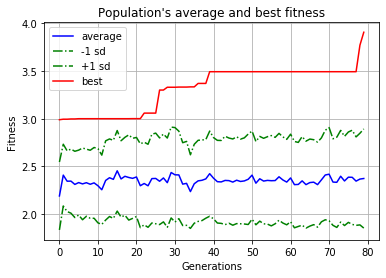

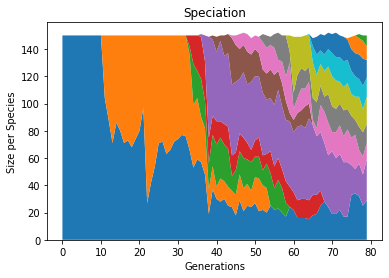

Mean genetic distance 2.632, standard deviation 1.168
Mean genetic distance 2.699, standard deviation 1.193
Mean genetic distance 2.675, standard deviation 1.161
Mean genetic distance 2.706, standard deviation 1.061
Mean genetic distance 2.818, standard deviation 1.224
Mean genetic distance 2.667, standard deviation 1.110
Mean genetic distance 2.723, standard deviation 1.053
Mean genetic distance 2.786, standard deviation 1.115
Mean genetic distance 2.804, standard deviation 1.222
Mean genetic distance 2.696, standard deviation 1.140


In [5]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2
            
def run(config_file):
    # 加载配置
    config = neat.Config(
        neat.DefaultGenome, 
        neat.DefaultReproduction,
        neat.DefaultSpeciesSet,
        neat.DefaultStagnation,
        config_file
    )
    # 产生种群
    p = neat.Population(config)
    # 添加记录者
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50))
    # 进化三百代
    winner = p.run(eval_genomes, 300)
    # 获胜者
    print('\nBest genome: \n{!s}'.format(winner))
    
    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
    # 以下这行暂时有点儿问题
    # draw_net(config, winner, True, node_names=node_names)
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)

    p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-49')
    p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    local_dir = os.path.dirname('./')
    config_path = os.path.join(local_dir, 'config-feedforward')
    run(config_path)  